# Redes Convolucionais


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

# Find out if using GPU
gpu = !nvidia-smi -L
print(gpu[0].split(' (')[0] if gpu[0].startswith('GPU') else 'Not using GPU')

# For more GPU information, run:
# !nvidia-smi

GPU 0: Tesla T4


In [ ]:
def plots(history, xlim=None, ylim=None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.title(f"Val accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();

# Treinando a partir do zero

## Fashion-MNIST

A partir de agora, realizaremos todo o pré-processamento internamente no modelo: https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model

Portanto, nem sequer faremos a divisão por 255; os dados continuarão como inteiros.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, random_state=0)
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
x_train.dtype: uint8
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


### Baseline densa

In [ ]:
# MLP

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255), # preprocessing applied inside the model
    Flatten(),
    Dense(300, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 238510 (931.68 KB)
Trainable params: 238510 (931.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def train(model, epochs, batch_size, lr, callbacks):
  from tqdm.keras import TqdmCallback
  callbacks = callbacks + [TqdmCallback(verbose=0)]
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
  history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_val, y_val), verbose=0, callbacks=callbacks, epochs=epochs)
  return history

0epoch [00:00, ?epoch/s]

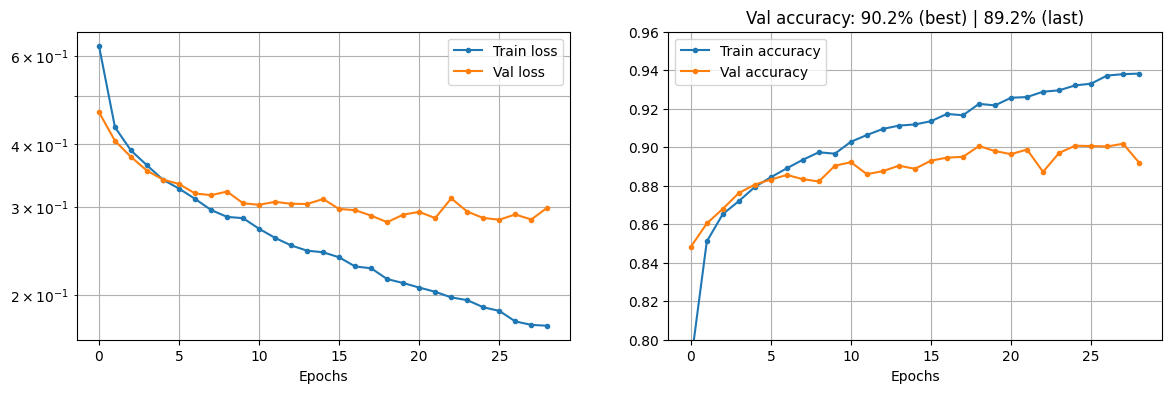

In [ ]:
history = train(model, epochs=100, batch_size=512, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# MLP with Dropout

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Flatten(),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28)            0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                3010      
                                                                 
Total params: 238510 (931.68 KB)
Trainable params: 238510 (931.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


0epoch [00:00, ?epoch/s]

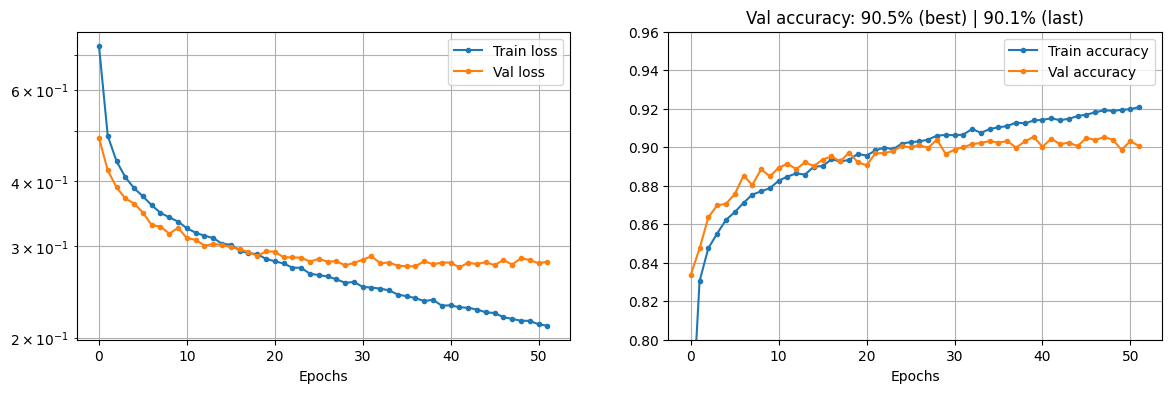

In [ ]:
history = train(model, epochs=100, batch_size=512, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

### Rede convolucional

Camadas convolucionais 2D exigem que a entrada seja um tensor 3D, sendo o último eixo correspondente ao número de canais (no caso, apenas 1, para uma imagem em tons de cinza).

In [ ]:
# CNN

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)), # convolutional layer requires shape height x width x n_channels
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                 

0epoch [00:00, ?epoch/s]

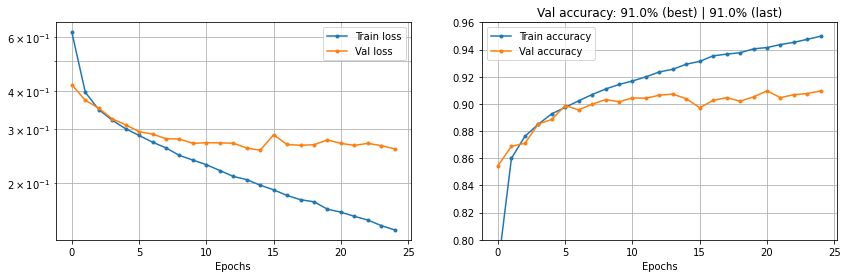

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# CNN with Dropout

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                 

0epoch [00:00, ?epoch/s]

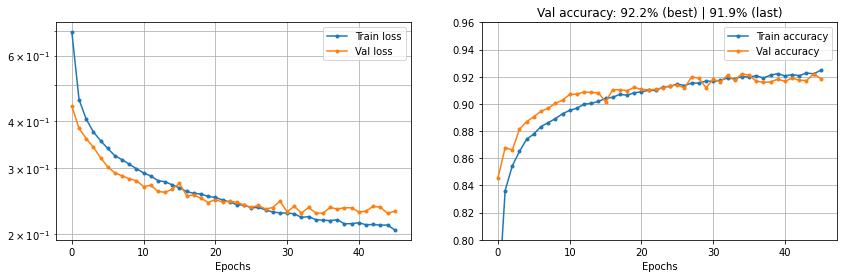

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# CNN with Dense layer

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                 

0epoch [00:00, ?epoch/s]

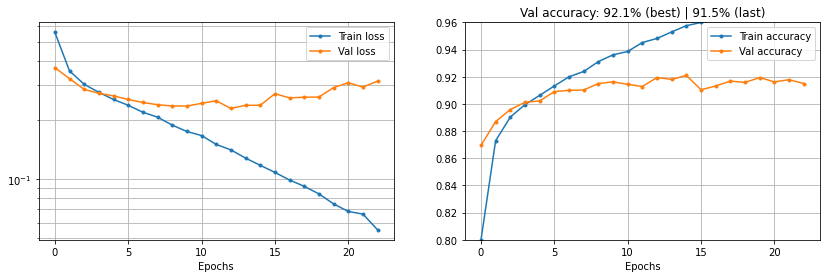

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# CNN with Dense layer and Dropout after

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

0epoch [00:00, ?epoch/s]

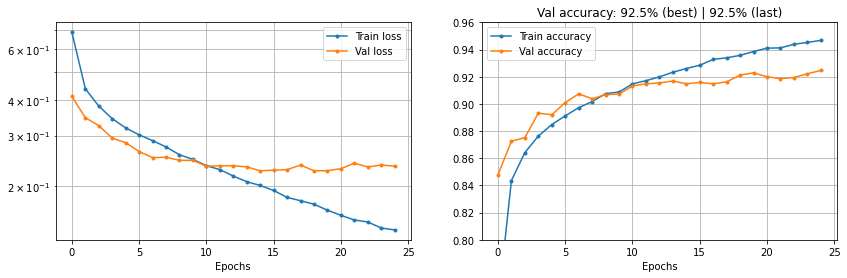

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# CNN with Dense layer and Dropout before

tf.random.set_seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape_4 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

0epoch [00:00, ?epoch/s]

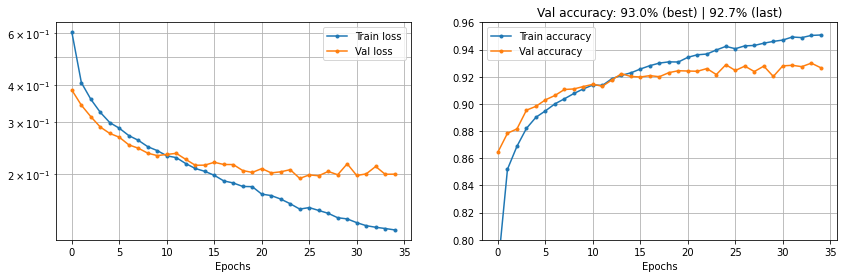

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

In [ ]:
# CNN with Dense layer and Dropout before and after

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(28, 28)),
    Rescaling(1/255),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 28, 28)            0         
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                 

0epoch [00:00, ?epoch/s]

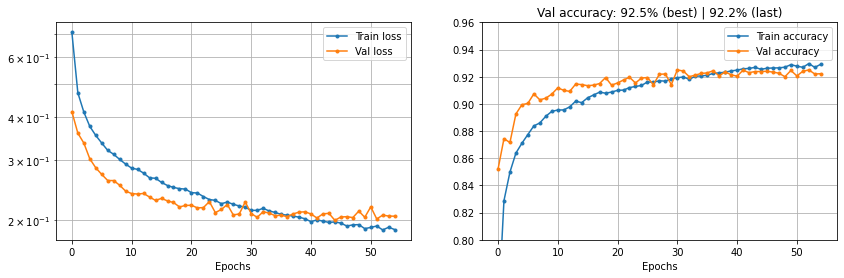

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.8, 0.96])

Outras abordagens que (aparentemente) não ajudam muito nesse problema:
- Alterar a taxa de dropout
- Adicionar dropout entre as camadas convolucionais
- Aumentar o número de unidades da camada densa
- Aumentar o número de filtros das camadas convolucionais
- Adicionar mais camadas densas
- Adicionar mais camadas convolucionais

## CIFAR-10

Agora, vamos utilizar um conjunto um pouco mais complexo, o [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), também [disponível no Keras](https://keras.io/datasets/).


In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 3s 0us/step
x_train.dtype: uint8
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
# Make sure y is a 1D tensor, so we can use sparse_categorical_crossentropy loss
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, random_state=0)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000,)
(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


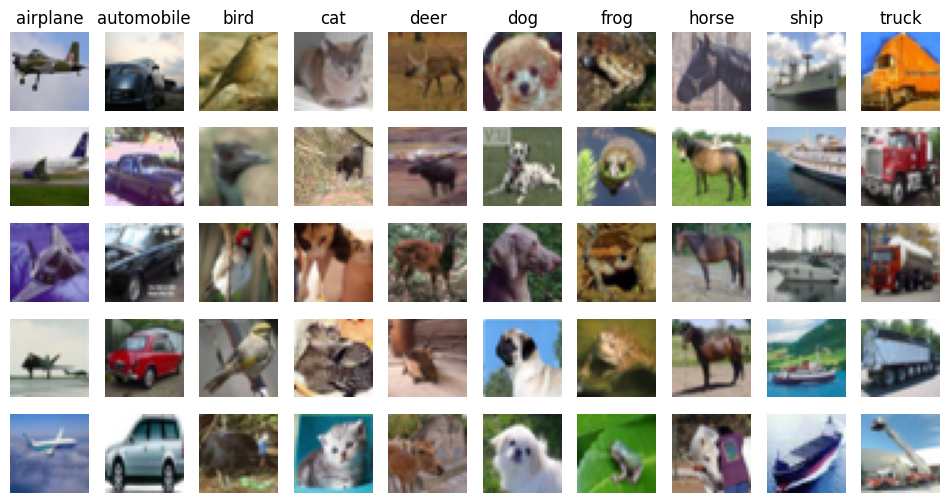

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 6))
for i in range(5):
  for c in range(10):
    plt.subplot(5, 10, 10*i+c+1)
    img = x_train[y_train == c][i]
    plt.imshow(img)
    if i == 0:
      plt.title(classes[c])
    plt.axis('off')

In [ ]:
# CNN from Fashion-MNIST adapted to CIFAR-10

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)),
    Rescaling(1/255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 2304)             

0epoch [00:00, ?epoch/s]

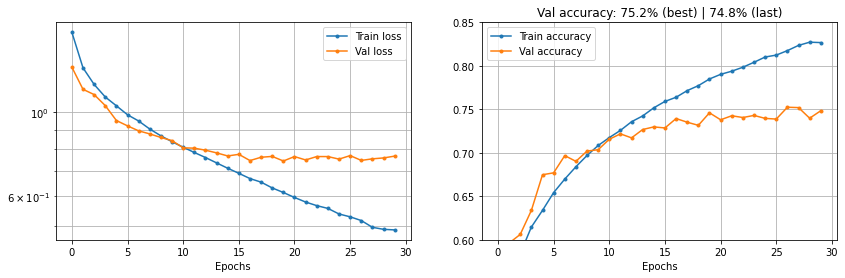

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.6, 0.85])

In [ ]:
# CNN from Fashion-MNIST adapted to CIFAR-10 (with dropout before and after)

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)),
    Rescaling(1/255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 2304)            

0epoch [00:00, ?epoch/s]

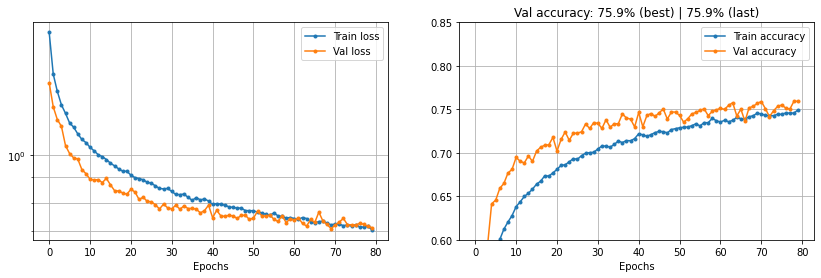

In [ ]:
history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
plots(history, ylim=[0.6, 0.85])

### Data augmentation
Para melhorar o desempenho, utilizaremos a técnica de aumento de dados (*data augmentation*). Há três formas principais de utilizar esta técnica no Keras:
- Usando a função [`tf.keras.preprocessing.image.ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), a qual opcionalmente permite aplicar transformações aleatórias durante o treinamento. Esta é a abordagem mais clássica, relativamente simples e usada em muitos tutoriais, porém é a menos eficiente computacionalmente.
- Usando a API [tf.data](https://www.tensorflow.org/guide/data#preprocessing_data) do TensorFlow para criar uma pipeline de pré-processamento dos dados de entrada (veja exemplos [aqui](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e [aqui](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).). Essa é uma abordagem mais moderna, flexível e mais eficiente computacionalmente que a primeira.
- Usando camadas de *data augmentation* como parte do modelo, as quais aplicam transformações aleatórias *somente* durante o treinamento (ficando inativas fora do treinamento). A principal vantagem é tornar as operações mais rápidas pelo uso da GPU, conforme explicado [neste tutorial](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e também [neste](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).

Para acelerar o treinamento usaremos aqui a última abordagem. Um exemplo é mostrado abaixo; você pode adicionar outras transformações se desejar.



In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, RandomCrop

data_augmentation = Sequential(
  [
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    RandomFlip(mode='horizontal'),
  ],
  name='data_augmentation',
)

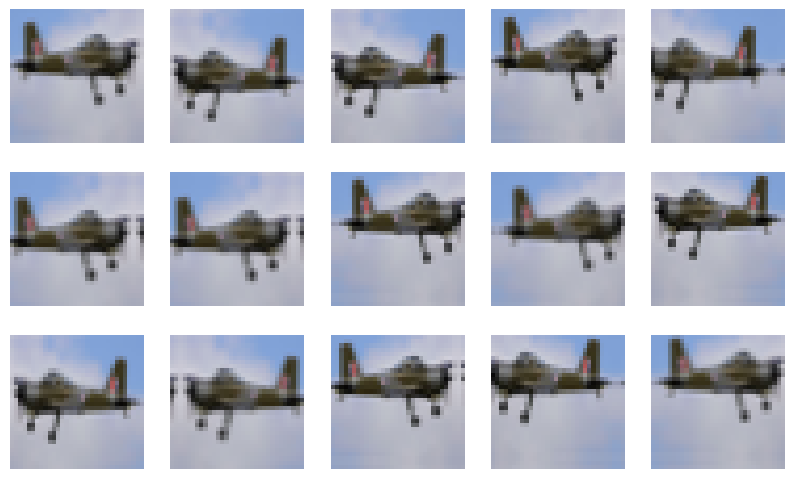

In [ ]:
plt.figure(figsize=(10, 6))
i = 5
for j in range(15):
  img = data_augmentation(x_train[[i]], training=True) # convert to (1, shape) before entering a Keras model
  img = img[0].numpy() # extract numpy array from tf.Tensor object
  # resulting dtype after data augmentation is 'float32'; must convert back to 'uint8' before plotting
  img = img.astype('uint8')
  plt.subplot(3, 5, j+1)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
# CNN with data augmentation only
tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)),
    data_augmentation,
    Rescaling(1/255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 32, 32, 3)         0         
 ial)                                                            
                                                                 
 rescaling_7 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)         

0epoch [00:00, ?epoch/s]

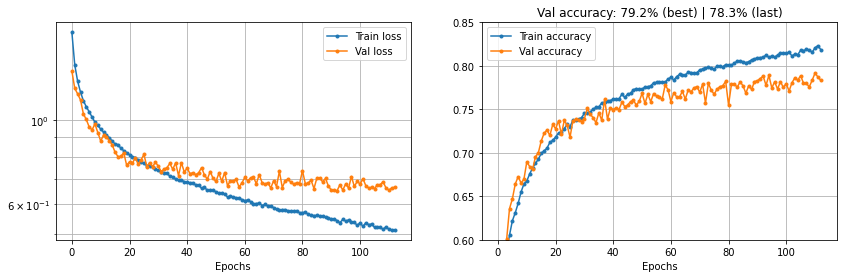

In [ ]:
history = train(model, epochs=200, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=20)])
plots(history, ylim=[0.6, 0.85])

In [ ]:
# CNN with data augmentation and dropout

tf.random.set_seed(0)
random.seed(0)
model = Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)),
    data_augmentation,
    Rescaling(1/255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
  ]
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 32, 32, 3)        0         
 al)                                                             
                                                                 
 rescaling_12 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 64)       

0epoch [00:00, ?epoch/s]

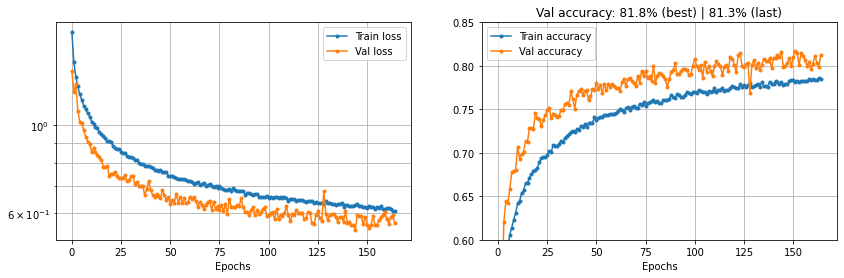

In [ ]:
history = train(model, epochs=200, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=20)])
plots(history, ylim=[0.6, 0.85])

### Learning rate scheduling

#### ReduceLROnPlateau

In [ ]:
# From now on, the model architecture will be kept fixed

def make_model():
  tf.random.set_seed(0)
  random.seed(0)
  model = Sequential(
    [
      InputLayer(input_shape=(32, 32, 3)),
      data_augmentation,
      Rescaling(1/255),
      Conv2D(32, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dropout(0.5),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax'),
    ]
  )
  return model

0epoch [00:00, ?epoch/s]


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


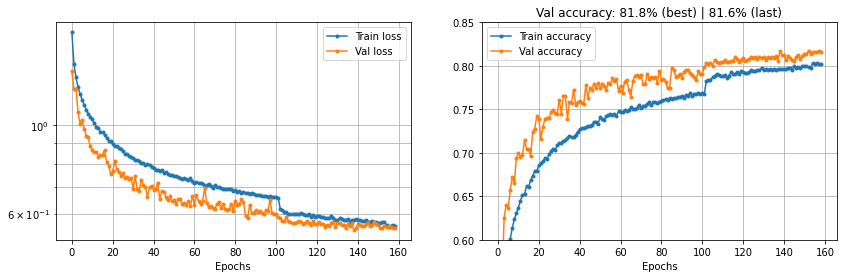

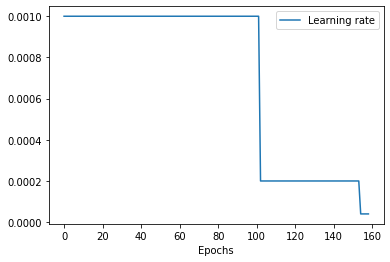

In [ ]:
callbacks = [EarlyStopping(patience=20), ReduceLROnPlateau(factor=0.2, patience=15, verbose=1)]
model = make_model()
history = train(model, epochs=200, batch_size=128, lr=0.001, callbacks=callbacks)
plots(history, ylim=[0.6, 0.85]); plt.show()
plt.plot(history.history['lr'], label='Learning rate'); plt.xlabel('Epochs'); plt.legend();

#### Linear schedule

In [ ]:
def make_linear_schedule(lrmax, epochs, warmup=0):
  warmup_epochs = int(warmup*epochs) if isinstance(warmup, float) else warmup
  def schedule(epoch, lr):
    if epoch < warmup_epochs:
      return lrmax*(epoch + 1)/(warmup_epochs + 1)
    t = (epoch - warmup_epochs)/(epochs - warmup_epochs)
    return lrmax*(1 - t)
  return schedule

0epoch [00:00, ?epoch/s]

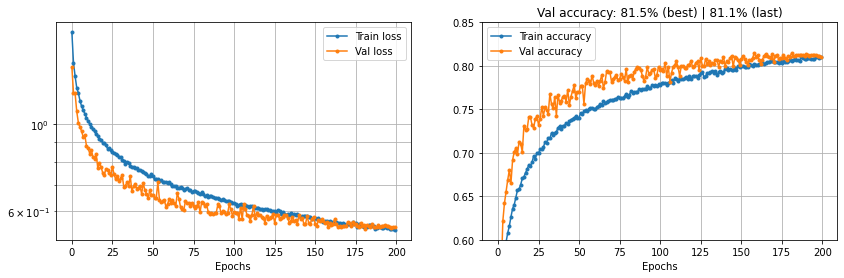

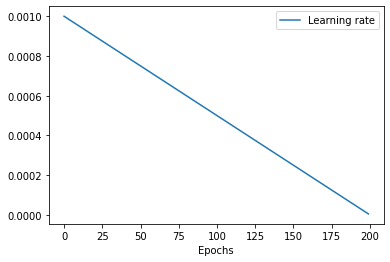

In [ ]:
epochs = 200
lr = 0.001
schedule = make_linear_schedule(lr, epochs)
model = make_model()
history = train(model, epochs=epochs, batch_size=128, lr=lr, callbacks=[LearningRateScheduler(schedule)])
plots(history, ylim=[0.6, 0.85]); plt.show()
plt.plot(history.history['lr'], label='Learning rate'); plt.xlabel('Epochs'); plt.legend();

Para tamanhos de batch grandes, às vezes pode ser útil incluir um período de `warm up` em que a taxa de aprendizado aumenta gradualmente até seu valor máximo, antes de começar a decair

0epoch [00:00, ?epoch/s]

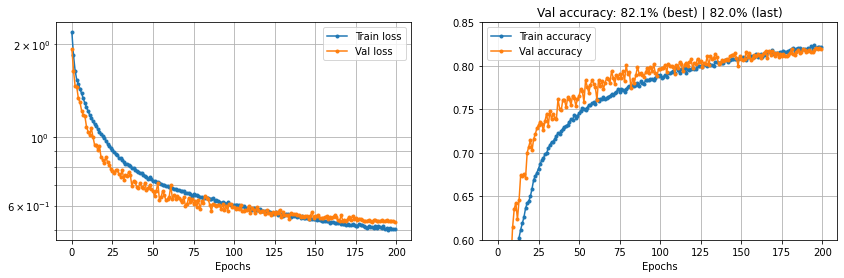

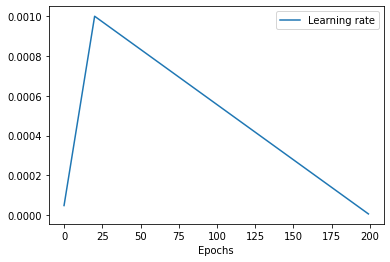

In [ ]:
epochs = 200
lr = 0.001
schedule = make_linear_schedule(lr, epochs, warmup=0.1)
model = make_model()
history = train(model, epochs=epochs, batch_size=128, lr=lr, callbacks=[LearningRateScheduler(schedule)])
plots(history, ylim=[0.6, 0.85]); plt.show()
plt.plot(history.history['lr'], label='Learning rate'); plt.xlabel('Epochs'); plt.legend();

Obs: pequenas variações de desempenho (neste caso específico, em torno de 0.5% ou mais) podem acontecer a cada novo treinamento, então devemos ter cuidado antes de concluir que alguma alteração teve impacto significativo no desempenho.

# Usando uma rede pré-treinada (*transfer learning & fine-tuning*)

Partindo de uma [rede pré-treinada](https://keras.io/applications/)  fornecida pelo Keras, iremos treinar uma rede convolucional para [classificação entre gatos e cachorros](https://www.kaggle.com/c/dogs-vs-cats). Referências:
- Módulo tf.data: https://www.tensorflow.org/guide/data
- API funcional do Keras: https://keras.io/guides/functional_api/
- Transfer learning em Keras: https://keras.io/guides/transfer_learning
- Tutorial específico da EfficientNet: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- Outras referências (mais antigas): [\[1\]](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/), [\[2\]](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

Obs: Se desejar, você também pode aplicar um modelo pré-treinado para classificar o CIFAR-10. No entanto, para obter um desempenho satisfatório nesse caso, será necessário previamente alargar (*resize*) as imagens para um tamanho mais próximo do das imagens da ImageNet (`224 x 224`), para que os filtros treinados possam ser relevantes. Por outro lado, um alargamento excessivo pode introduzir distorções (*artifacts*) que podem prejudicar o desempenho.


In [ ]:
import tensorflow_datasets as tfds

#setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

train_ds, val_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))
print("Number of test samples:", len(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0CQ65Z/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [ ]:
#tf.data.Dataset.from_tensor_slices()

In [ ]:
for img, lab in train_ds.take(1):
  pass
img, lab

(<tf.Tensor: shape=(262, 350, 3), dtype=uint8, numpy=
 array([[[242, 248, 248],
         [240, 246, 246],
         [235, 239, 238],
         ...,
         [188, 174, 127],
         [145, 133,  85],
         [161, 149, 101]],
 
        [[238, 244, 244],
         [239, 245, 245],
         [235, 239, 238],
         ...,
         [188, 176, 128],
         [165, 153, 105],
         [178, 168, 119]],
 
        [[237, 241, 240],
         [238, 242, 241],
         [232, 236, 235],
         ...,
         [200, 187, 142],
         [201, 191, 142],
         [200, 192, 143]],
 
        ...,
 
        [[130, 122,  75],
         [152, 146,  98],
         [154, 148,  98],
         ...,
         [161, 166, 136],
         [ 77,  86,  57],
         [ 71,  82,  52]],
 
        [[167, 159, 112],
         [105,  99,  51],
         [148, 142,  92],
         ...,
         [ 67,  73,  45],
         [ 46,  56,  29],
         [ 41,  54,  26]],
 
        [[138, 130,  83],
         [ 83,  77,  29],
         [135,

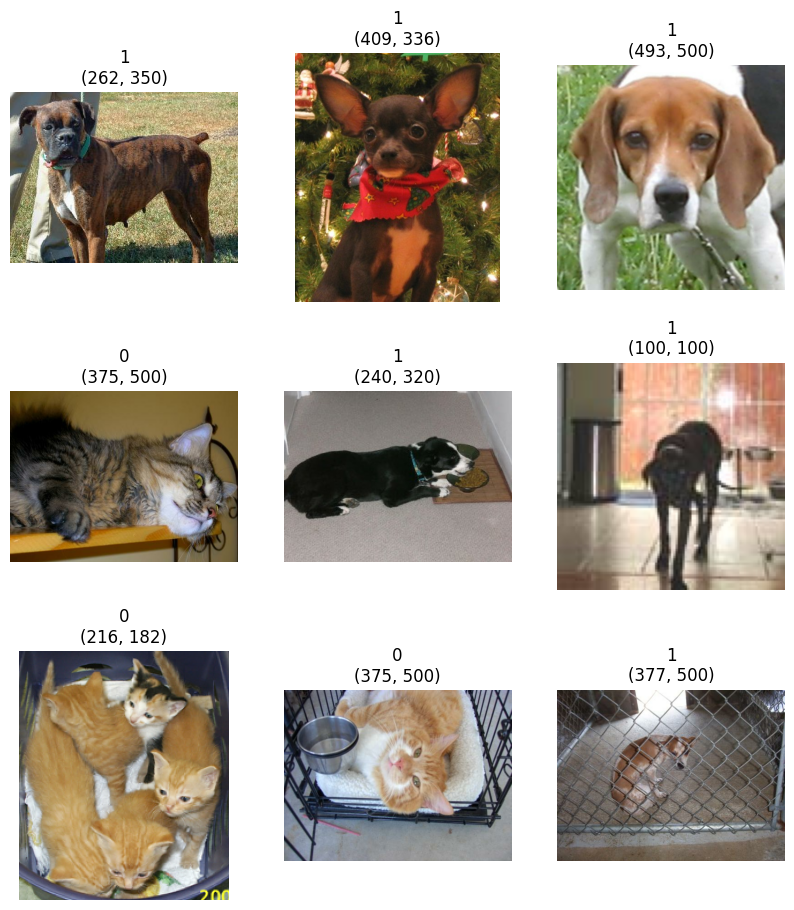

In [ ]:
plt.figure(figsize=(10, 1.1*10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f'{label}\n{image.shape[:2]}')
    plt.axis('off')

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds   =   val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds  =  test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

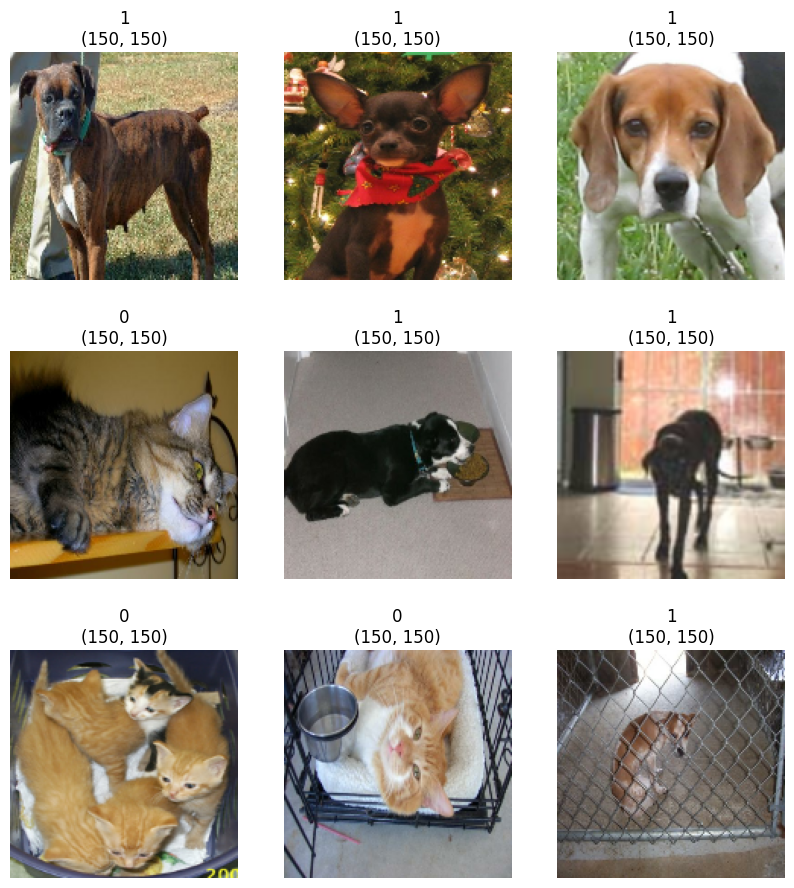

In [ ]:
plt.figure(figsize=(10, 1.1*10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  # image dtype becomes float after resize, so have to map to [0, 1] for imshow
  image = image/255
  plt.imshow(image)
  plt.title(f'{label}\n{image.shape[:2]}')
  plt.axis('off')

- Caching: https://www.tensorflow.org/guide/data_performance#caching
- Prefetching: https://www.tensorflow.org/guide/data_performance#optimize_performance

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   =   val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  =  test_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 150, 150, 3) (32,)


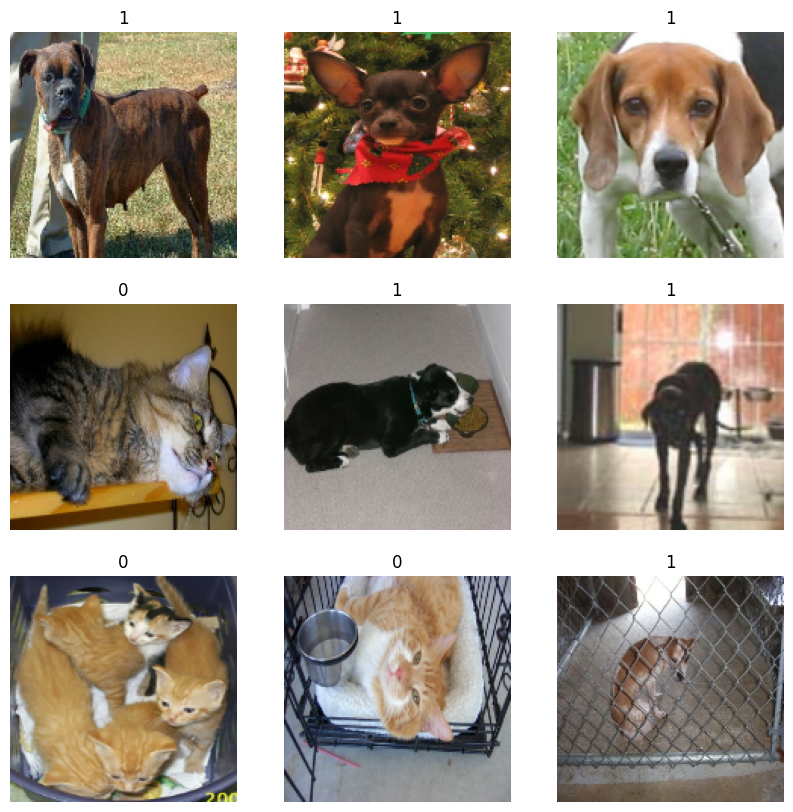

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images.shape, labels.shape)
  for i, image in enumerate(images[:9]):
    label = labels[i]
    ax = plt.subplot(3, 3, i + 1)
    image = image/255
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

In [ ]:
from tensorflow.keras.layers import RandomRotation, RandomFlip
data_augmentation = Sequential(
    [
     RandomFlip('horizontal'),
     RandomRotation(0.1),
    ],
    name='data_augmentation'
)

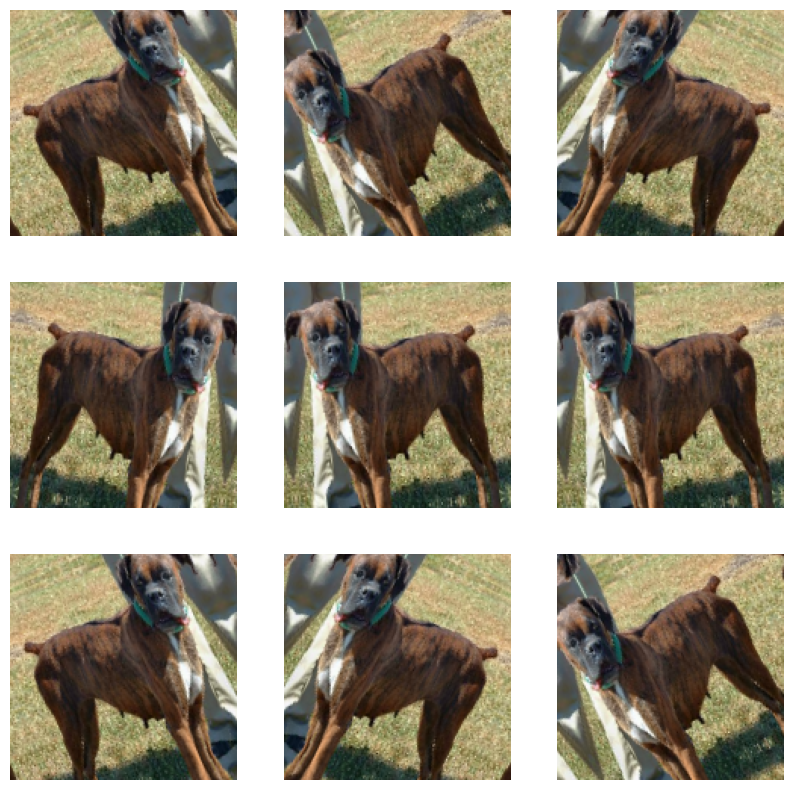

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = data_augmentation(tf.expand_dims(images[0], 0), training=True)[0]
    image = image/255
    plt.imshow(image)
    plt.axis('off')

### Transfer learning

Antes de utilizar um modelo com a opção `include_top=False`, é útil inspecionar o modelo completo (com a opção `include_top=True`), uma vez que será necessário recriar (e retreinar) as camadas finais removidas.

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
model = Xception()

91884032/91884032 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_9[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

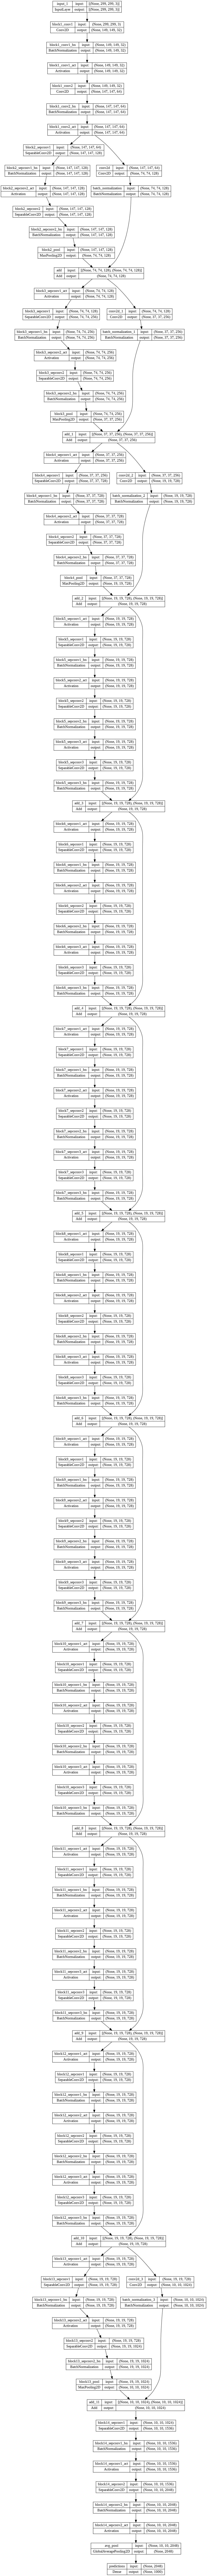

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.layers[-5:]

Antes de aplicar um modelo pré-treinado, geralmente é necessário realizar algum pré-processamento exigido pelo modelo. Ao invés de realizar esse pré-processamento manualmente (como feito no tutorial do Keras), é suficiente e mais conveniente utilizar a função `preprocess_input`, disponível no módulo de cada modelo pré-treinado.

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/preprocess_input
# The input must be: "A floating point numpy.array or a tf.Tensor, 3D or 4D with 3 color channels, with values in the range [0, 255]"
# What the function does: "The inputs pixel values are scaled between -1 and 1, sample-wise."

In [ ]:
preprocess_input(np.array([0, 255]))

array([-1.,  1.], dtype=float32)

In [ ]:
Rescaling(scale=1/127.5, offset=-1)([0, 255]).numpy()

array([-1.,  1.], dtype=float32)

Aqui usamos a API funcional do Keras para construir o modelo. Inicialmente deixamos o modelo pré-treinado com os pesos congelados e treinamos apenas a camada de saída.

A opção `training=False` na chamada do `base_model` é necessária para garantir que as estatísticas de batch estimadas pela camada `BatchNormalization` durante o treinamento do modelo original não sejam alteradas. Essas estatísticas (média $\mu_x$ e variância $\sigma_x^2$) correspondem aos 54528 parâmetros não-treináveis vistos no `summary` do Xception mostrado acima.

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.xception import Xception, preprocess_input
#from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

input_shape = size + (3,)  # (150, 150, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 2048)              2086148

In [ ]:
%%time
epochs = 3
lr = 0.001

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
291/291 [==============================] - 54s 172ms/step - loss: 0.1630 - accuracy: 0.9326 - val_loss: 0.0847 - val_accuracy: 0.9673
Epoch 2/3
291/291 [==============================] - 50s 171ms/step - loss: 0.1158 - accuracy: 0.9516 - val_loss: 0.0809 - val_accuracy: 0.9699
Epoch 3/3
291/291 [==============================] - 50s 171ms/step - loss: 0.1103 - accuracy: 0.9543 - val_loss: 0.0785 - val_accuracy: 0.9690
CPU times: user 45.1 s, sys: 4.53 s, total: 49.7 s
Wall time: 3min 5s


#### From logits

Abordagem alternativa para função de ativação + função de perda, que pode evitar alguns problemas de precisão numérica. Usada no tutorial de transfer learning, embora não faça diferença perceptível nesse problema específico.

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.xception import Xception, preprocess_input
#from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

input_shape = size + (3,)  # (150, 150, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.2)(x)

#x = Dense(1, activation='sigmoid')(x)
x = Dense(1)(x) # logits

model = Model(i, x)
model.summary()

In [ ]:
epochs = 3
lr = 0.001

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
model.compile(loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()], optimizer=Adam(learning_rate=lr))

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

### Fine-tuning

Agora descongelamos os pesos do modelo pré-treinado para mais uma etapa de treinamento com taxa de aprendizado baixa, de forma a obter mais um pequeno ganho de desempenho

In [ ]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                             

In [ ]:
epochs = 3
lr = 1e-5 # Low learning rate

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
291/291 [==============================] - 190s 633ms/step - loss: 0.0815 - accuracy: 0.9687 - val_loss: 0.0519 - val_accuracy: 0.9768
Epoch 2/3
291/291 [==============================] - 182s 627ms/step - loss: 0.0599 - accuracy: 0.9766 - val_loss: 0.0460 - val_accuracy: 0.9807
Epoch 3/3
284/291 [============================>.] - ETA: 4s - loss: 0.0467 - accuracy: 0.9836

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
291/291 [==============================] - 182s 625ms/step - loss: 0.0355 - accuracy: 0.9856 - val_loss: 0.0519 - val_accuracy: 0.9802
Epoch 2/3
291/291 [==============================] - 183s 629ms/step - loss: 0.0278 - accuracy: 0.9894 - val_loss: 0.0458 - val_accuracy: 0.9845
Epoch 3/3
291/291 [==============================] - 183s 628ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 0.0442 - val_accuracy: 0.9828


#### From logits

In [ ]:
base_model.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

In [ ]:
epochs = 6
lr = 1e-5 # Low learning rate

model.compile(loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()], optimizer=Adam(learning_rate=lr))
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/6
291/291 [==============================] - 192s 629ms/step - loss: 0.0873 - binary_accuracy: 0.9659 - val_loss: 0.0488 - val_binary_accuracy: 0.9807
Epoch 2/6
291/291 [==============================] - 183s 628ms/step - loss: 0.0608 - binary_accuracy: 0.9758 - val_loss: 0.0430 - val_binary_accuracy: 0.9832
Epoch 3/6
291/291 [==============================] - 183s 628ms/step - loss: 0.0456 - binary_accuracy: 0.9831 - val_loss: 0.0427 - val_binary_accuracy: 0.9832
Epoch 4/6
 20/291 [=>............................] - ETA: 2:41 - loss: 0.0355 - binary_accuracy: 0.9859

KeyboardInterrupt: ignored